In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost
!pip install lightgbm
!pip install ngboost
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 8.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=ea3d03491bf5e49658d943abc2297d5d0156ab681d0b2b851b03270b67f458be
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.4 MB/s eta 0:00:00


In [ ]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Essentials
import numpy as np
import pandas as pd
import random
import time
import gc
import os
from datetime import datetime

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns
# matplotlib 의 기본 scheme 말고
# seaborn scheme 을 세팅하여, 일일이 graph의 font size 지정할 필요 없이
# seaborn 의 font_scale 을 사용하는 것을 추천드립니다.
plt.style.use('seaborn')
sns.set(font_scale=2.5)
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 80,60

# Models
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from ngboost import NGBClassifier, NGBRegressor
from lightgbm.plotting import plot_importance
import lightgbm
import xgboost as xgb
import catboost
from xgboost import plot_tree

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


# Misc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.pipeline import make_pipeline

import shap

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

<Figure size 1600x800 with 0 Axes>

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/model/4.22_land_modi_update1.csv'
df = pd.read_csv(path)
df

,Unnamed: 0,dti,funded_amnt_inv,installment,int_rate,loan_amnt,mort_acc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,num_accts_ever_120_pd,pub_rec,pub_rec_bankruptcies,loan_status,emp_length_int,issue_d_year,issue_d_month,grade_numeric,fico_range_mean,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,1,17.41,35000.0,822.95,14.47,35000.0,0.0,30.0,154.0,0.0,0.0,0.0,Current,2.0,2018,9,5,717.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,34.70,23200.0,680.82,24.99,23200.0,2.0,126.0,277.0,0.0,0.0,0.0,Charged Off,10.0,2016,7,3,672.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,14.95,4500.0,145.06,9.93,4500.0,0.0,127.0,265.0,1.0,0.0,0.0,Current,10.0,2017,12,6,677.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,17.74,16000.0,494.55,7.07,16000.0,3.0,134.0,400.0,0.0,0.0,0.0,Charged Off,0.0,2017,10,7,822.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,6,6.99,4500.0,146.10,10.42,4500.0,1.0,226.0,130.0,0.0,2.0,2.0,Fully Paid,5.0,2017,5,6,702.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535702,1755290,19.18,3600.0,133.78,19.99,3600.0,1.0,151.0,36.0,0.0,0.0,0.0,Charged Off,7.0,2014,3,3,667.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1535703,1755291,23.92,18875.0,583.89,6.68,19000.0,5.0,125.0,216.0,0.0,0.0,0.0,Fully Paid,4.0,2015,4,7,737.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1535704,1755292,12.85,9600.0,329.65,14.33,9600.0,1.0,25.0,99.0,0.0,0.0,0.0,Fully Paid,9.0,2013,5,5,692.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1535705,1755293,20.94,24000.0,744.90,7.35,24000.0,2.0,54.0,151.0,1.0,0.0,0.0,Fully Paid,5.0,2018,2,7,737.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 필요 없는 부분 제거
df.drop(columns = 'Unnamed: 0', inplace = True)

In [ ]:
not_deliq = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']

loan_stat = df['loan_status']
target = []
for stat in loan_stat:
    # 연체 하지 않은 경우를 0
    if stat in not_deliq:
        target.append(0)
    # 연체한 경우를 1
    else:
        target.append(1)
print(len(target))
print(len(df))

1535707
1535707


In [ ]:
df['target'] = target

In [ ]:
# current와 issued를 제거
df = df[df['loan_status']!= 'Current']
df = df[df['loan_status']!= 'Issued']

In [ ]:
df.drop(columns = 'loan_status', inplace = True)

In [ ]:
# X와 y를 나누기 위해 list 생성
x_data = list(df.columns)
x_data.remove('target')

In [ ]:
# 우선 랜덤하게 data_split하고 돌려봄 6:2:2
df_train, df_test = train_test_split(df, test_size = .2, train_size = .8, random_state = 42)
df_train, df_validation = train_test_split(df_train, test_size = .25, train_size = 0.75, random_state = 42)

In [ ]:
X_train = df_train[x_data]
y_train = df_train['target']

X_test = df_validation[x_data]
y_test = df_validation['target']
# Target

In [ ]:
df_train.describe()

,dti,funded_amnt_inv,installment,int_rate,loan_amnt,mort_acc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,num_accts_ever_120_pd,pub_rec,pub_rec_bankruptcies,emp_length_int,issue_d_year,issue_d_month,grade_numeric,fico_range_mean,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,target
count,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.00000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000,643668.000000
mean,18.025871,14357.809808,434.422265,13.129037,14386.980439,1.551819,125.080198,179.718106,0.489937,0.208926,0.132012,5.638898,2015.506783,6.505472,5.314566,699.342964,0.486717,0.000020,0.000099,0.111149,0.40134,0.223906,0.569966,0.000241,0.065893,0.006045,0.022462,0.011938,0.006940,0.061039,0.000735,0.011211,0.007230,0.001279,0.247096,0.012228,0.007389,0.024202,0.143485,0.021812,0.015239,0.002526,0.002877,0.071619,0.032296,0.004906,0.000009,0.001575,0.039259,0.016157,0.008236,0.009505,0.011268,0.023442,0.023806,0.001849,0.026313,0.017553,0.015727,0.005307,0.002762,0.027823,0.001359,0.003025,0.004855,0.036455,0.005315,0.014894,0.082182,0.032745,0.008902,0.012090,0.033982,0.004644,0.012082,0.001989,0.015446,0.081225,0.007137,0.028039,0.002035,0.021289,0.013091,0.003572,0.002100,0.195972
std,8.411955,8839.889803,262.617189,4.791274,8838.690218,1.939864,51.882367,94.733228,1.332858,0.612509,0.372349,3.794231,1.845590,3.428572,1.270803,32.407086,0.499824,0.004494,0.009971,0.314317,0.49017,0.416860,0.495081,0.015516,0.248095,0.077515,0.148180,0.108606,0.083017,0.239402,0.027098,0.105286,0.084724,0.035735,0.431324,0.109904,0.085641,0.153676,0.350568,0.146071,0.122503,0.050197,0.053563,0.257857,0.176786,0.069873,0.003053,0.039659,0.194212,0.126081,0.090376,0.097029,0.105552,0.151303,0.152444,0.042958,0.160065,0.131318,0.124418,0.072656,0.052485,0.164467,0.036845,0.054915,0.069508,0.187420,0.072709,0.121130,0.274642,0.177969,0.093930,0.109288,0.181182,0.067986,0.1092

In [ ]:
def show_time(diff):
   m, s = divmod(diff, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def Train(clf, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    model = clf.fit(X,y)
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('\nPrediction time: ')
    show_time(end - start)
    return model


# Takes in model scores and plots them on a bar graph
def plot_metric(model_scores, score='Accuracy'):
    # Set figure size
    rcParams['figure.figsize'] = 20,15
    plt.bar(model_scores['Model'], height=model_scores[score])
    xlocs, xlabs = plt.xticks()
    xlocs=[i for i in range(0,17)]
    xlabs=[i for i in range(0,17)]
    if(score != 'Prediction Times'):
        for i, v in enumerate(model_scores[score]):
            plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
    plt.xlabel('Model')
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()

# Takes in training data and a model, and plots a bar graph of the model's feature importances
def feature_importances(df, model, model_name, max_num_features=10):
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = df.columns
    feature_importances['importance'] = model.feature_importances_
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    print(feature_importances)
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title(model_name+' features importance:');

# Takes in training data and a model, and plots a bar graph of SHAP values
def shap_values(df, model, model_name):
    shap_values = shap.TreeExplainer(model).shap_values(df)
    shap_values[:5]
    shap.summary_plot(shap_values, df.iloc[:1000,:])

NgBoost Hyperparameter list up
https://github.com/stanfordmlgroup/ngboost/blob/51a299197ae77dff88826156edf386313201d99b/ngboost/api.py#L21

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
prediction_times = []
training_times = []
scores = []
# training_times
# prediction_times

lin_svm = Train(LinearSVC(), X_train, y_train, X_test, y_test) # linear suppor vector machine
#non_lin_svm = Train(SVC(kernel='rbf'), X_train, y_train, X_test, y_test) # non ---
decision_tree = Train(DecisionTreeClassifier(max_depth=5), X_train, y_train, X_test, y_test) # 결정트리
random_forest= Train(RandomForestClassifier(n_estimators=50,max_depth=5), X_train, y_train, X_test, y_test) # 랜덤 포레스트. Essemble 중 bagging에 대표적인 모델
extra_trees = Train(ExtraTreesClassifier(n_estimators=50,max_depth=5), X_train, y_train, X_test, y_test) # 랜덤 포레스트와 유사하지만, bagging은 아니다. 속도도 빠르고 bias도 varinace도 줄일 수 있다고 하지만... 최고라고 하기엔 흠?
xgboost = Train(XGBClassifier(n_estimators=50, max_depth=5), X_train, y_train, X_test, y_test)
lgb = Train(LGBMClassifier(n_estimators=50, max_depth=5), X_train, y_train, X_test, y_test)
cat = Train(CatBoostClassifier(n_estimators=50, verbose=False, max_depth=5), X_train, y_train, X_test, y_test)
ngb = Train(NGBClassifier(n_estimators=50, verbose=False, natural_gradient=False), X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:06:08

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:06

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:28

Prediction time: 
Execution Time: 00:00:01
Training time: 
Execution Time: 00:00:19

Prediction time: 
Execution Time: 00:00:01
Training time: 
Execution Time: 00:00:12

Prediction time: 
Execution Time: 00:00:00
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 126141, number of negative: 517527
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074065 seconds.
You can set `force_row_wise=true` to remove the overhead.


In [ ]:
models = [
    ('LinearSVM', lin_svm),
#    ('NonLinearSVM', non_lin_svm),
    ('DecisionTree', decision_tree),
    ('RandomForest', random_forest),
    ('ExtraTrees', extra_trees),
    ('XGBoost', xgboost),
    ('LightGBM', lgb),
    ('CatBoost', cat),
    ('NgBoost', ngb)
]

In [ ]:
# score에 있는 점수를 소수점 5째자리까지 반올림
for i in range(len(scores)):
    scores[i] = round(scores[i],5)
scores

[0.80204, 0.80281, 0.80204, 0.80204, 0.80548, 0.8052, 0.80504, 0.80204]

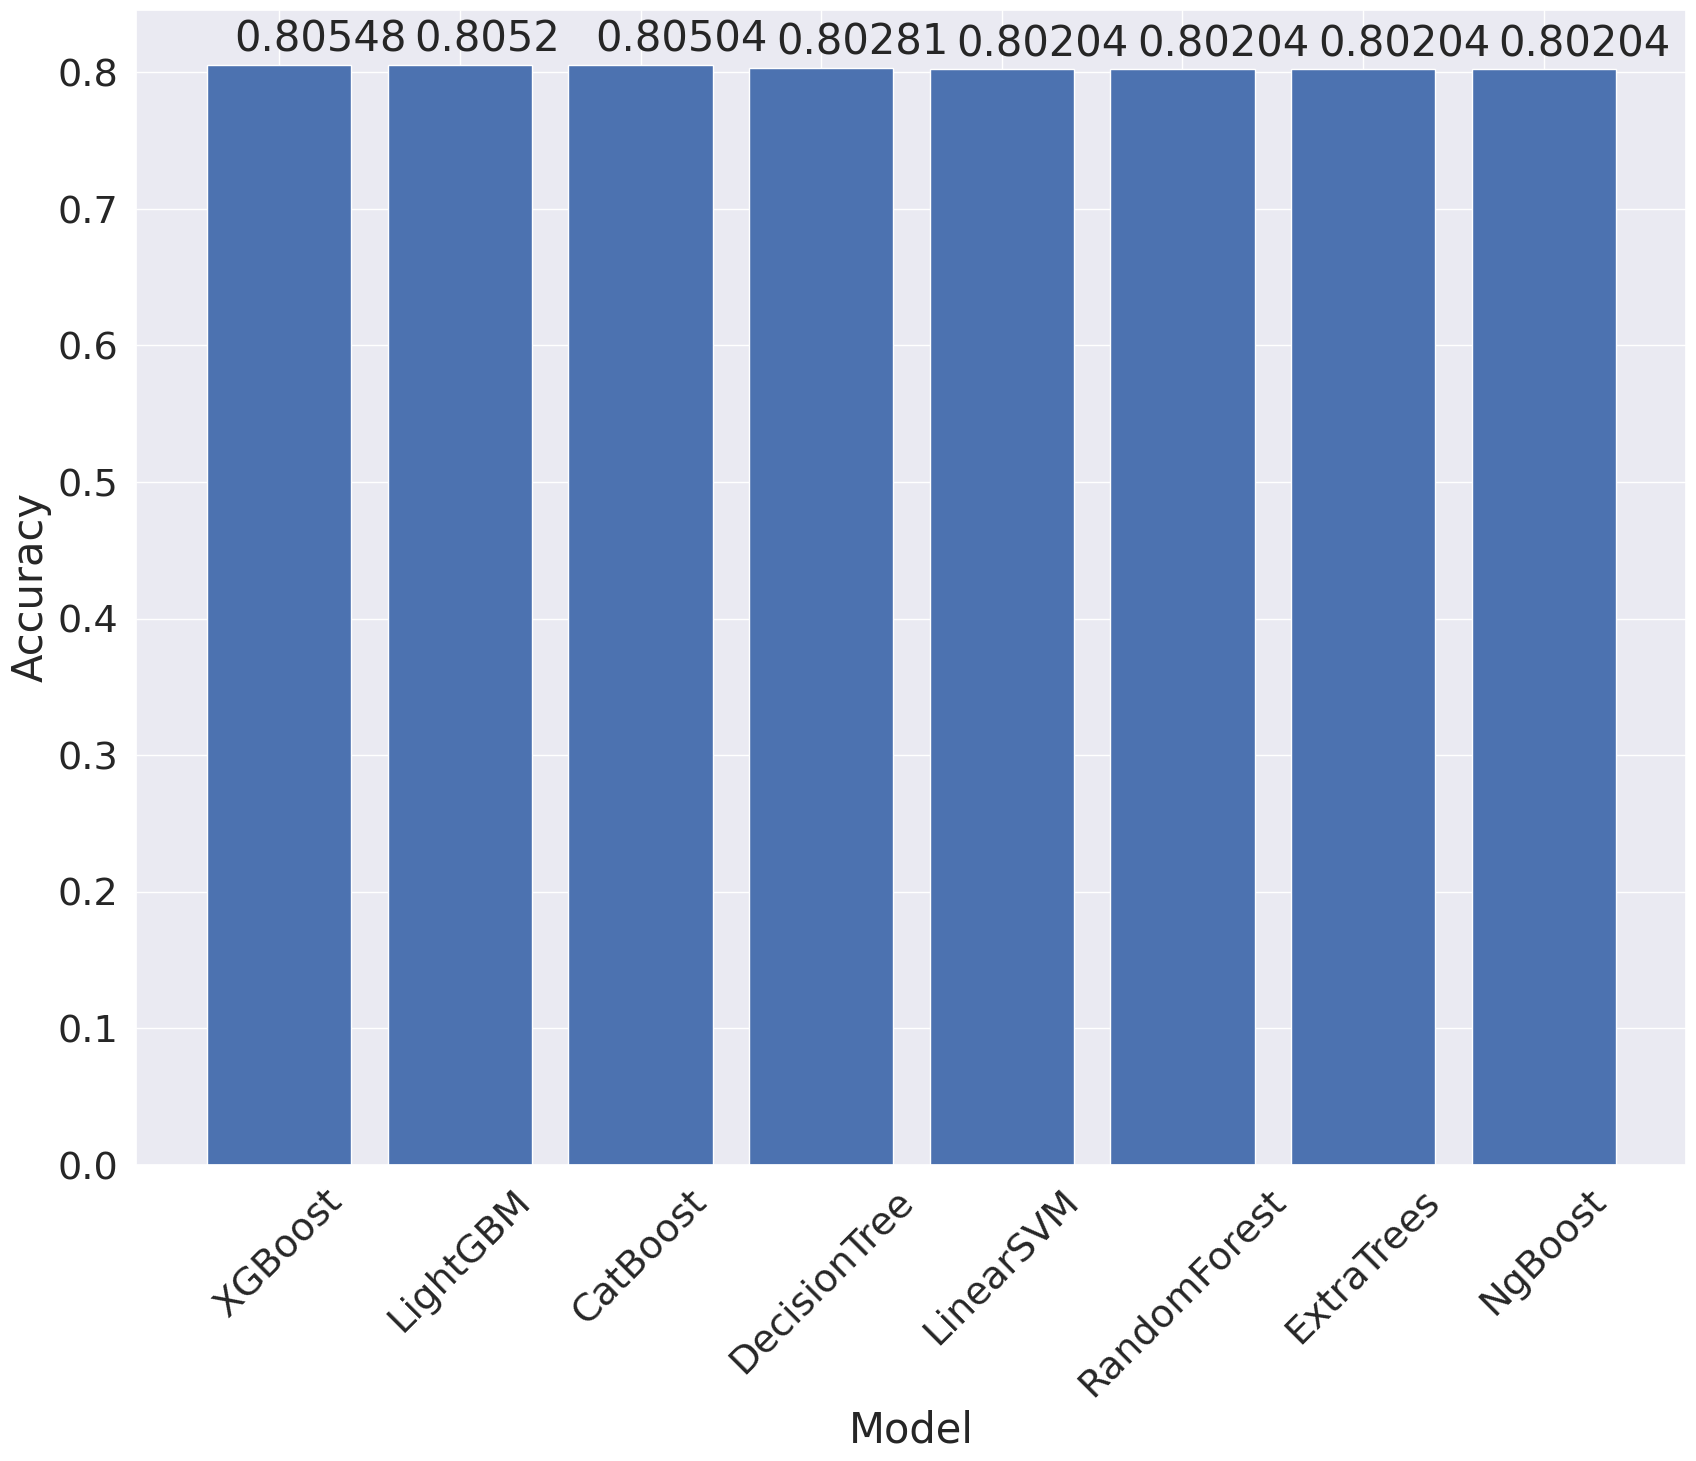

In [ ]:
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'Accuracy': scores })
model_scores.sort_values(by='Accuracy',ascending=False,inplace=True)
plot_metric(model_scores, score='Accuracy')

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrices = {}
# 각 모델에 대한 전퓨전 매트릭스 상성
for name, model in models:
    # 모델의 예측값 얻기
    y_pred = model.predict(X_test)
    # 컨퓨전 매트릭스 생성
    cm = confusion_matrix(y_test, y_pred)
    # 딕셔너리에 저장
    confusion_matrices[name] = cm

# 컨퓨전 매트릭스 출력
for name, cm in confusion_matrices. items():
    print(f"Confusion Matrix for {name}")
    print (cm)
    print()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Confusion Matrix for LinearSVM
[[172083      0]
 [ 42473      0]]

Confusion Matrix for DecisionTree
[[169573   2510]
 [ 39799   2674]]

Confusion Matrix for RandomForest
[[172083      0]
 [ 42473      0]]

Confusion Matrix for ExtraTrees
[[172083      0]
 [ 42473      0]]

Confusion Matrix for XGBoost
[[169407   2676]
 [ 39060   3413]]

Confusion Matrix for LightGBM
[[170546   1537]
 [ 40258   2215]]

Confusion Matrix for CatBoost
[[169504   2579]
 [ 39251   3222]]

Confusion Matrix for NgBoost
[[172083      0]
 [ 42473      0]]

